#EDA and Clustering project

In [2]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
import scipy.cluster.hierarchy as sch

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

#let's try some SQL code to see how it works in python
!pip install pandasql
from pandasql import sqldf



  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26781 sha256=e165fac3040853b51ddb7ef90af67541b1d205fa47940af986f519f6838c7457
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [3]:
#import the dataset
path='//content/drive/MyDrive/DataSets'
df=pd.read_csv(path+'/uk_ecommerce.csv',sep=',',encoding='latin-1')
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,7-Dec-17,0.85,12680.0,France,NaN
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,7-Dec-17,2.10,12680.0,France,NaN
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,7-Dec-17,4.15,12680.0,France,NaN
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,7-Dec-17,4.15,12680.0,France,NaN
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,7-Dec-17,4.95,12680.0,France,NaN


In [ ]:
#let's see what the data looks like
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
 8   Unnamed: 8   0 non-null       float64
dtypes: float64(3), int64(1), object(5)
memory usage: 37.2+ MB


In [4]:
#Let's add and additional column with the total revenue for purchase
df['Total_Revenue']=df['Quantity']*df['UnitPrice']

In [ ]:
#Let´s see the NaN or null values in the df and evaluate if they affect the EDA or the clustering
df.isna().sum()

InvoiceNo             0
StockCode             0
Description        1454
Quantity              0
InvoiceDate           0
UnitPrice             0
CustomerID       135080
Country               0
Unnamed: 8       541909
Total_Revenue         0
dtype: int64

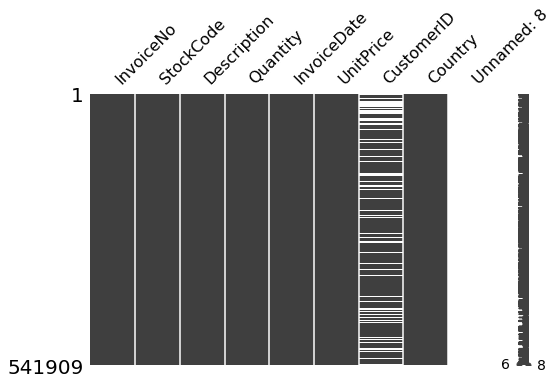

In [ ]:
msno.matrix(df,figsize=(8,5))

In [5]:
#The column 'unnamed:8' is completely empty, and 135080 values in 'CustomeeID are missed.
#For EDA analysis we will keep the rows with no CustomerId and replace the NaN with 0, and drop 'unnamed:8'empty column
df_eda=df.drop(columns=['Unnamed: 8'])
df_eda=df_eda.fillna(0)
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   InvoiceNo      541909 non-null  object 
 1   StockCode      541909 non-null  object 
 2   Description    541909 non-null  object 
 3   Quantity       541909 non-null  int64  
 4   InvoiceDate    541909 non-null  object 
 5   UnitPrice      541909 non-null  float64
 6   CustomerID     541909 non-null  float64
 7   Country        541909 non-null  object 
 8   Total_Revenue  541909 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 37.2+ MB


#Clustering algorithm

For clustering, we need to identify customers with similar purchases behavior and then group them into clusters. 
* identify the number of customer segments
* Find the customers who are hightly valued

In [28]:
#let's group the purchases by customer
df_sales=sqldf("SELECT CustomerID, COUNTRY, COUNT(InvoiceNo) AS Total_purchases, SUM(Total_Revenue) as Total_Revenue, SUM(Quantity) as Quantity FROM df GROUP BY CustomerID ORDER BY Quantity desc;")
df_sales.head()

,CustomerID,Country,Total_purchases,Total_Revenue,Quantity
0,NaN,United Kingdom,135080,1447682.12,269562
1,14646.0,Netherlands,2085,279489.02,196719
2,12415.0,Australia,778,123725.45,77242
3,14911.0,EIRE,5903,132572.62,77180
4,17450.0,United Kingdom,351,187482.17,69029


In [29]:
#For clustering, we need to drop all the missing values from the df, 
#We need to find the significant customers for the business, so purchases with no CustomerID are useless
df_sales.dropna(inplace=True)

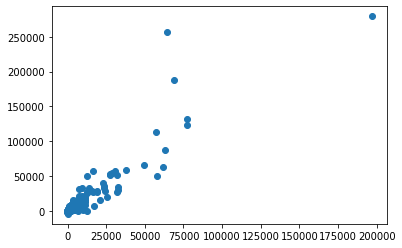

In [ ]:
#now, let's see how the data is distributed
plt.scatter(df_sales['Quantity'], df_sales['Total_Revenue'])

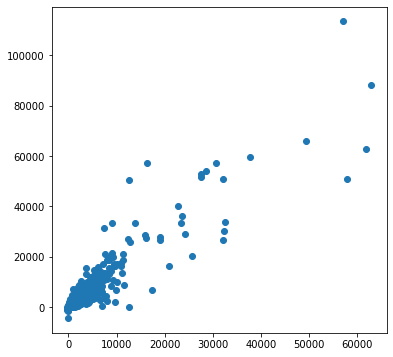

In [30]:
#Here we can see outliers, to better intify the cluster centers, we need to set limits to the top values of Total_revenue and Quantity
df_clustering=sqldf("SELECT CustomerID,	Total_purchases,	Total_Revenue,	Quantity FROM df_sales WHERE Total_Revenue <150000 and Quantity <70000")
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
plt.scatter(df_clustering['Quantity'], df_clustering['Total_Revenue'])

##Scaling using minmax scaler

In [31]:
scaler=MinMaxScaler()
scaler.fit(df_clustering[['Quantity']])
df_clustering['Quantity_scaled']=scaler.transform(df_clustering[['Quantity']])

scaler.fit(df_clustering[['Total_Revenue']])
df_clustering['Revenue_scaled']=scaler.transform(df_clustering[['Total_Revenue']])
df_clustering.head()

,CustomerID,Total_purchases,Total_Revenue,Quantity,Quantity_scaled,Revenue_scaled
0,17511.0,1076,88125.38,63012,1.000000,0.785346
1,13694.0,585,62653.10,61803,0.980905,0.568877
2,14298.0,1640,50862.44,58021,0.921172,0.468677
3,14156.0,1420,113384.14,57025,0.905441,1.000000
4,16684.0,281,65892.08,49390,0.784854,0.596402


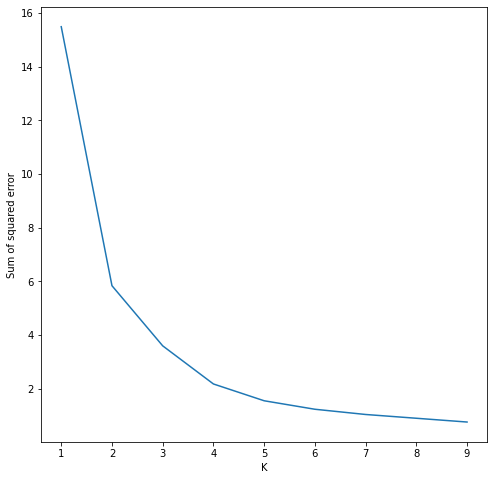

In [33]:
#Now we need to find the k-clusters. Let's use the Elbow method to find them
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df_clustering[['Quantity_scaled','Revenue_scaled']])
    sse.append(km.inertia_)

fig, axes = plt.subplots(1,1,figsize=(8,8))
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

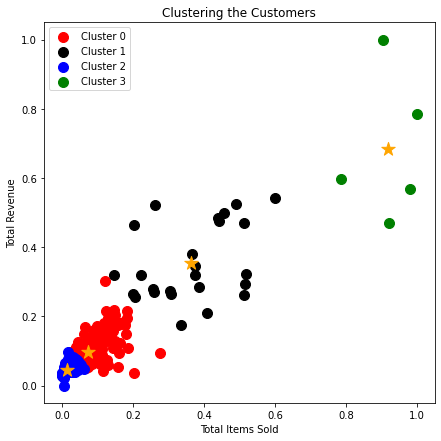

In [53]:
#Let's trye Kmean method with the scaled data
km=KMeans(n_clusters=4)
points=df_clustering[['Quantity_scaled','Revenue_scaled']].to_numpy()
y_km=km.fit_predict(points)

fig, axes = plt.subplots(1,1,figsize=(7,7))
Cluster_0=plt.scatter(points[y_km ==0,0], points[y_km == 0,1], s=100, c='red')
Cluster_1=plt.scatter(points[y_km ==1,0], points[y_km == 1,1], s=100, c='black')
Cluster_2=plt.scatter(points[y_km ==2,0], points[y_km == 2,1], s=100, c='blue')
Cluster_3=plt.scatter(points[y_km ==3,0], points[y_km == 3,1], s=100, c='green')


plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='orange',marker='*',label='centroid',s=200)
plt.xlabel('Total Items Sold')
plt.ylabel('Total Revenue')
plt.title('Clustering the Customers')
plt.legend([Cluster_0,Cluster_1,Cluster_2,Cluster_3],['Cluster 0','Cluster 1','Cluster 2','Cluster 3'])

##other methods

No handles with labels found to put in legend.


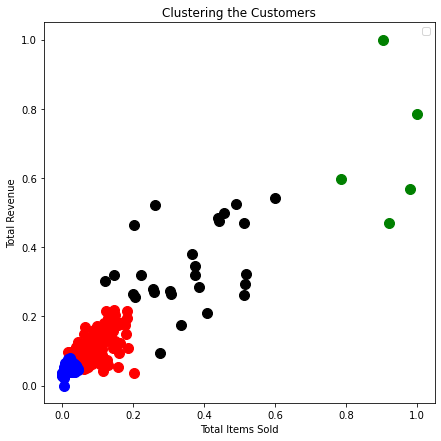

In [34]:
#Agglomerative Cluster
agg = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
y_agg = agg.fit_predict(points)

fig, axes = plt.subplots(1,1,figsize=(7,7))
plt.scatter(points[y_agg ==0,0], points[y_agg == 0,1], s=100, c='red')
plt.scatter(points[y_agg ==1,0], points[y_agg == 1,1], s=100, c='black')
plt.scatter(points[y_agg ==2,0], points[y_agg == 2,1], s=100, c='blue')
plt.scatter(points[y_agg ==3,0], points[y_agg == 3,1], s=100, c='green')

plt.xlabel('Total Items Sold')
plt.ylabel('Total Revenue')
plt.title('Clustering the Customers')
ax.legend()


In [54]:
df_clustering["cluster_agg"] = agg.labels_
df_clustering["cluster_km"] = km.labels_
df_clustering.head(10)

,CustomerID,Total_purchases,Total_Revenue,Quantity,Quantity_scaled,Revenue_scaled,cluster_agg,cluster_km
0,17511.0,1076,88125.38,63012,1.000000,0.785346,3,3
1,13694.0,585,62653.10,61803,0.980905,0.568877,3,3
2,14298.0,1640,50862.44,58021,0.921172,0.468677,3,3
3,14156.0,1420,113384.14,57025,0.905441,1.000000,3,3
4,16684.0,281,65892.08,49390,0.784854,0.596402,3,3
5,15311.0,2491,59419.34,37720,0.600537,0.541396,1,1
6,16422.0,399,33805.69,32592,0.519545,0.323725,1,1
7,17404.0,201,30300.82,32324,0.515312,0.293940,1,1
8,16333.0,45,26626.80,32184,0.513101,0.262717,1,1
9,16029.0,274,50992.61,32148,0.512533,0.469783,1,1


Text(0.5, 1.0, 'DBSCAN')

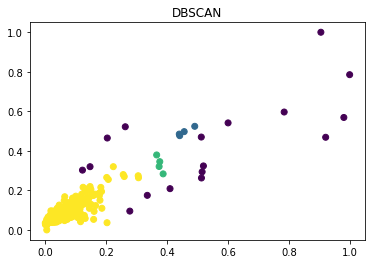

In [40]:
#let's import a third method: DBSCAN
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.06,min_samples=4)
db.fit(points)
y_pred = db.fit_predict(points)
plt.scatter(points[:,0], points[:,1],c=y_pred)
plt.title("DBSCAN")

#DBSCAN algorithm did not work very well this time due to the diferent density of each cluster



#EDA
* What was the total revenue?
* Which months had the higher sales?
* What products are in the top 10 in sales and revenue?
* Which products were returned more frequently?
* What was the total loss?
* What are the top 5 countries that purchesed the most?
* What is the share of revenue for each cluster?

In [6]:
#What was the total revenue?
Sum_revenue=df_eda.Total_Revenue.sum()
print ('Total Revenue:\n','$ ', round(Sum_revenue,2))

Total Revenue:
 $  9747747.93


In [7]:
#In which months the sales were higher?

#let's separate the year and month
import datetime as dt
df_eda['InvoiceDate']=pd.to_datetime(df_eda['InvoiceDate'])

df_eda['Month']=df_eda['InvoiceDate'].dt.month
df_eda['Year']=df_eda['InvoiceDate'].dt.year

In [8]:
#total amount per year
by_month=df_eda.groupby(df_eda['InvoiceDate'].dt.year).count().InvoiceDate
by_month

InvoiceDate
2016     42481
2017    499428
Name: InvoiceDate, dtype: int64

In [9]:
Total_per_month=df_eda.groupby(['Year','Month'])['Total_Revenue'].sum()
Total_per_month

Year  Month
2016  11        104842.840
      12        644114.180
2017  1         609481.930
      2         492349.140
      3         663890.700
      4         475780.001
      5         769062.060
      6         651601.730
      7         704438.401
      8         725412.070
      9         952269.532
      10       1133061.700
      11       1496272.650
      12        325171.000
Name: Total_Revenue, dtype: float64

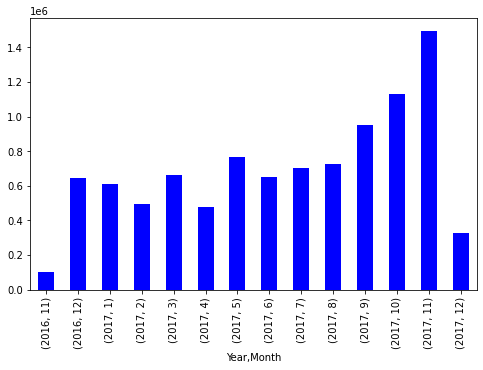

In [ ]:
Total_per_month.plot(kind='bar', color='blue',figsize=(8,5))

In [10]:
#What products are the top 10 in sales and Revenue?
Top_products=df_eda[['StockCode','Description','Quantity','Total_Revenue']].groupby(['StockCode','Description'],as_index=False).sum(['Quantity','Total_Revenue']).sort_values(by='Quantity',ascending=False)
Top_products.head(10)

,StockCode,Description,Quantity,Total_Revenue
4283,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,53847,13587.93
5068,85099B,JUMBO BAG RED RETROSPOT,47363,92356.03
4759,84879,ASSORTED COLOUR BIRD ORNAMENT,36381,58959.73
1695,22197,POPCORN HOLDER,36334,33969.46
691,21212,PACK OF 72 RETROSPOT CAKE CASES,36039,21059.72
5100,85123A,WHITE HANGING HEART T-LIGHT HOLDER,35025,97715.99
2812,23084,RABBIT NIGHT LIGHT,30680,66756.59
2021,22492,MINI PAINT SET VINTAGE,26437,16810.42
2185,22616,PACK OF 12 LONDON TISSUES,26315,7972.76
1443,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24753,12189.47


In [11]:
Top_products.sort_values(by='Total_Revenue', ascending=False)

,StockCode,Description,Quantity,Total_Revenue
5737,DOT,DOTCOM POSTAGE,707,206245.480
1931,22423,REGENCY CAKESTAND 3 TIER,13033,164762.190
3877,47566,PARTY BUNTING,18022,98302.980
5100,85123A,WHITE HANGING HEART T-LIGHT HOLDER,35025,97715.990
5068,85099B,JUMBO BAG RED RETROSPOT,47363,92356.030
...,...,...,...,...
5712,BANK CHARGES,Bank Charges,-13,-7175.639
5715,CRUK,CRUK Commission,-16,-7933.430
5711,B,Adjust bad debt,3,-11062.060
5738,M,Manual,3164,-68674.190


In [28]:
#Let's create a df with the products with negative revenue
df_loss=df_eda[['Description','Quantity','Total_Revenue']].loc[df_eda['Total_Revenue']<0].sort_values(by='Total_Revenue')
df_loss.groupby('Description').sum().sort_values(by='Total_Revenue')

,Quantity,Total_Revenue
Description,,
AMAZON FEE,-32,-235281.59
"PAPER CRAFT , LITTLE BIRDIE",-80995,-168469.60
Manual,-4066,-146784.46
MEDIUM CERAMIC TOP STORAGE JAR,-74494,-77479.64
Adjust bad debt,2,-22124.12
...,...,...
STRIPY DESIGN SHOWER CAP,-1,-0.29
FRENCH STYLE STORAGE JAR JAM,-1,-0.29
RECYCLED PENCIL WITH RABBIT ERASER,-1,-0.21


In [32]:
#Which products were returne or discarte more frequently?
df_loss.sort_values(by='Quantity')

,Description,Quantity,Total_Revenue
540422,"PAPER CRAFT , LITTLE BIRDIE",-80995,-168469.60
61624,MEDIUM CERAMIC TOP STORAGE JAR,-74215,-77183.60
4287,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,-280.80
160145,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3114,-6539.40
160144,GIN + TONIC DIET METAL SIGN,-2000,-3700.00
...,...,...,...
210958,PARISIENNE KEY CABINET,-1,-5.75
437122,PARISIENNE KEY CABINET,-1,-5.75
529694,CHILLI LIGHTS,-1,-5.75
299983,Adjust bad debt,1,-11062.06


In [29]:
#What was the total loss
df_loss.sum()

Description      PAPER CRAFT , LITTLE BIRDIEMEDIUM CERAMIC TOP ...
Quantity                                                   -277572
Total_Revenue                                              -918937
dtype: object

In [27]:
#What is the top 5 countries that purchesed the most?
df_countries=df_eda[['Country','Quantity','Total_Revenue']].groupby(['Country'],as_index=False).sum().sort_values(by='Quantity',ascending=False)
df_countries.head()

,Country,Quantity,Total_Revenue
36,United Kingdom,4263829,8.187806e+06
24,Netherlands,200128,2.846615e+05
10,EIRE,142637,2.632768e+05
14,Germany,117448,2.216982e+05
13,France,110480,1.974039e+05


In [64]:
#What is the share of revenue for each cluster?
#To answer this question
df_share=df_clustering[['cluster_km','Total_Revenue']].groupby(['cluster_km'],as_index=False).sum().sort_values(by='Total_Revenue',ascending=False)

In [81]:
#Let's calculate the share % for each cluster
df_share['share (%)']=df_share['Total_Revenue']/[df_share['Total_Revenue'].sum()]*100
df_share['share (%)']=df_share['share (%)'].round(2)

In [86]:
#Let's see how many clients have each cluster
df_share['Total_clients']=df_clustering['cluster_km'].value_counts()
df_share

,cluster_km,Total_Revenue,share (%),Total_clients
2,2,3670668.374,50.14,4016
0,0,2337837.260,31.94,321
1,1,930935.290,12.72,25
3,3,380917.140,5.20,5
